# Análise de prestação de contas de partidos políticos no ano de 2020
#### Por Abel Cavalcante

---

Instalações e imports de bibliotecas importantes:

In [107]:
%pip install BeautifulSoup4 -U
%pip install camelot-py[cv]
%pip install excalibur-py

Requirement already up-to-date: BeautifulSoup4 in /home/abel/.local/lib/python3.8/site-packages (4.11.1)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [108]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import camelot
import random
import pprint
import time
import re
import os

# Scraping
from webdriver_manager.chrome import ChromeDriverManager
from keys import EXTENSION_LINK, API_KEY
from bs4 import BeautifulSoup

from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium import webdriver

Definição de um Header e criação de um dicionário contendo:

1. O nome do partido;
2. O Número do processo que contém o extrato da prestação de conta.

In [109]:
# Header
headers = {
     'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.32  (KHTML, like Gecko) Chrome/75.0.3770.139 Safari/537.32'
}

# Consulta às prestações de contas de feitas em 2020
link_2020 = "https://www.tse.jus.br/partidos/contas-partidarias/prestacao-de-contas/integra-da-prestacao-de-contas-e-demonstrativos-dos-partidos-referentes-a-2020"
request_prestacao_2020 = requests.get(link_2020, headers=headers)
request_prestacao_2020.encoding = 'utf-8'
print(f"URL: {link_2020}\nStatus Code: {request_prestacao_2020.status_code}")
print("-----------------------------------------------------")

# Procurando o número do processo de prestação de contas de cada partido
soup_demost = BeautifulSoup(request_prestacao_2020.text, 'html.parser')
lista_processos = soup_demost \
    .find('table', class_= "plain table") \
    .find('tbody') \
    .find_all('tr')
lista_processos.pop(0)

print(f"Total de processos: {len(lista_processos)}")
print("-----------------------------------------------------")

# Cria o dicionário Partido:Processo
partido_processo = {}
for linha in lista_processos:
    element = linha.find_all('td')
    partido = element[0].text
    processo = element[2].text.strip('\n')
    if re.match(r'\d+', processo):
        partido_processo[partido] = processo

print(f"Conjunto de partidos e processos:")
pprint.pprint(partido_processo)

URL: https://www.tse.jus.br/partidos/contas-partidarias/prestacao-de-contas/integra-da-prestacao-de-contas-e-demonstrativos-dos-partidos-referentes-a-2020
Status Code: 200
-----------------------------------------------------
Total de processos: 36
-----------------------------------------------------
Conjunto de partidos e processos:
{'AVANTE': '0600308-46.2021.6.00.0000',
 'CIDADANIA': '0600385-55.2021.6.00.0000',
 'DC': '0600348-28.2021.6.00.0000',
 'DEM': '0600297-17.2021.6.00.0000',
 'MDB': '0600349-13.2021.6.00.0000',
 'NOVO': '0600307-61.2021.6.00.0000',
 'PATRIOTA': '0600306-76.2021.6.00.0000',
 'PCB': '0600109-24.2021.6.00.0000',
 'PCO': '0600337-96.2021.6.00.0000',
 'PCdoB': '0600388-10.2021.6.00.0000',
 'PDT': '0600386-40.2021.6.00.0000',
 'PL': '0600294-62.2021.6.00.0000',
 'PMB': '0600336-14.2021.6.00.0000',
 'PMN': '0600390-77.2021.6.00.0000',
 'PODE': '0600289-40.2021.6.00.0000',
 'PP': '0600391-62.2021.6.00.0000',
 'PROS': '0600287-70.2021.6.00.0000',
 'PRTB': '0600293-

Aqui é criado um driver usando o Google Chrome e, junto com ele, é instalado uma extensão chamada *Buster*. Essa extensão tem como objetivo passar por reCAPTCHAs usados em sites, neste caso o de consulta unificada de processos do TSE. Assim, os seguintes passos são seguidos:

1. O driver é criado e configurado junto com a extensão;
2. O site de consulta pública é acessado, já com o número do processo na URL, e o reCAPTCHA é quebrado, caso necessário;

A extensão, todavia, necessita de um programa de identificação e conversão de voz para texto. Nesse caso, é usado o sistema da Azure, onde foi provida uma API KEY, que permite que a extensão funcione:

In [110]:
# Faz o programa parar em tempos aleatórios
def random_time(x, y):
    time.sleep(random.uniform(x, y))

# Configura o Driver com a extensão
chrome_options = Options()
chrome_options.add_extension('Buster.crx.crx')
driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)

# Configuração o Buster com a API Key
driver.get(EXTENSION_LINK)
wait = WebDriverWait(driver, 120)
wait.until(EC.element_to_be_clickable((By.CLASS_NAME ,"mdc-select"))).click()
wait.until(EC.element_to_be_clickable((By.XPATH, "//*[@class='mdc-list']/li[5]"))).click()
wait.until(EC.element_to_be_clickable((By.XPATH, "//*[@class='mdc-text-field mdc-ripple-upgraded']/input"))).send_keys(API_KEY)



====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
Driver [/home/abel/.wdm/drivers/chromedriver/linux64/102.0.5005.61/chromedriver] found in cache
/tmp/ipykernel_8895/882416550.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install(), options=chrome_options)


Após a configuração da extensão e quebra do reCAPTCHA, o arquivo *EXTRATO_PRESTACAO_CONTAS* é baixado para todos os partidos:

In [111]:
# Faz nova consulta para cada partido usando o Selenium
count = 0
falhas = []
for partido, processo in partido_processo.items():
    url_processo = f"https://consultaunificadapje.tse.jus.br/#/public/resultado/{processo}"

    # Faz a consulta, variando sites para que o programa não seja bloqueado
    driver.get("https://example.com/")
    driver.get(url_processo)
    random_time(1, 2)
    
    try:
        # Resolve o ReCAPTCHA, caso necessário
        driver.switch_to.frame(driver.find_elements(by=By.TAG_NAME, value="iframe")[0])
        checkbox = wait.until(EC.presence_of_element_located((By.ID ,"recaptcha-anchor")))
        random_time(0.5, 1.5)
        checkbox.click()

        random_time(2, 3)
        driver.switch_to.default_content()
        driver.switch_to.frame(driver.find_elements(by=By.TAG_NAME, value="iframe")[2])
        reacptcha_sound = wait.until(EC.presence_of_element_located((By.XPATH , '//*[@class="rc-buttons"]/div[2]')))
        random_time(0.5, 1.5)
        reacptcha_sound.click()

        random_time(2, 3)
        driver.switch_to.default_content()
        driver.switch_to.frame(driver.find_elements(by=By.TAG_NAME, value="iframe")[2])
        reacptcha_sound_resolver = wait.until(EC.presence_of_element_located((By.XPATH , '//*[@class="rc-buttons"]/div[4]')))
        random_time(0.5, 1.5)
        reacptcha_sound_resolver.click()

    except:
        pass

    random_time(2, 3)
    driver.switch_to.default_content()
    wait.until(EC.presence_of_element_located((By.XPATH , '//*[@class="tramitacao-card mat-card"]')))
    
    # Baixa o EXTRATO_PRESTACAO_CONTAS usando o Soup
    page_html = driver.page_source
    soup_processo = BeautifulSoup(page_html, 'html.parser')
    try:
        pdf_links = soup_processo.find('mat-card', class_= "tramitacao-card mat-card").find_all('a')
        href_pdf = [link.get('href') for link in pdf_links]
        extrato_pdf = [link for link in href_pdf if "EXTRATO_PRESTACAO_CONTAS" in link][0]
        
        pdf_response = requests.get(extrato_pdf, headers=headers)
        with open(f"PDFs/EXTRATO_{partido}.pdf", "wb") as f:
            f.write(pdf_response.content)

        count += 1

    except Exception as e:
        falhas.append(f"Erro em EXTRATO_{partido}.pdf: {e}.")
        pass

    
    print(f"{count} de {len(lista_processos)} arquivos baixados!", end='\r')

print("\n")
print(f"Falhas:\n{falhas}")

driver.quit()

32 de 36 arquivos baixados!

Falhas:
['Erro em EXTRATO_PCB.pdf: list index out of range.']


Após o download dos arquivos, todas as tabelas são extraídas utilizando a biblioteca camelot, e os dados são separados em dos DataFrames principais: **Elencos de Origem**, que se trata de onde veio o dinheiro do partido, e os **Elencos de Aplicações**, que se tratam de onde o dinheiro foi gasto.

In [113]:
# Separação dos dados em duas tabelas diferentes
df_origin = []
df_aplic = []
n_tabelas = 0
count = 0
size = len(os.listdir("PDFs"))

for file in os.listdir("PDFs"):
    tabelas = camelot.read_pdf(f"PDFs/{file}", pages='all')


    for tabela in tabelas:
        df = tabela.df
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header
        if (df.columns[1] == "Elenco de Origens"):
            df_origin.append(df)
        elif (df.columns[1] == "Elenco de Aplicações"):
            df_aplic.append(df)

    count += 1
    n_tabelas += len(tabelas)
    print(f"{count} de {size} arquivos processados!", end='\r')

print("\n-----------------------------------------------------")
print(f"{n_tabelas} tabelas processadas!")

32 de 32 arquivos processados!
-----------------------------------------------------
176 tabelas processadas!


In [114]:
try:
    all_df_origin = pd.concat(df_origin)
except:
    print("Não há tabela de Origens")

try:
    all_df_aplic = pd.concat(df_aplic)
except:
    print("Não há tabela de Aplicações")

In [145]:
print(f"Linhas: {all_df_origin.shape[0]}, Colunas: {all_df_origin.shape[1]}")
all_df_origin.head()

Linhas: 496, Colunas: 4


,Código,Elenco de Origens,Fonte do Recurso,Valor Total
1,2.1.3.05.02.01.,RECURSOS DE ORIGEM NÃO IDENTIFICADA,Fundo Especial de\nFinanciamento de\nCampanha,"R$ 5,0000"
2,4.1.3.01.01.,FUNDO ESPECIAL DE FINANCIAMENTO DE CAMPANHA - ...,Fundo Especial de\nFinanciamento de\nCampanha,"R$ 28.121.267,6400"
3,4.1.3.02.01.01.,SOBRAS FINANCEIRAS DE CAMPANHA - candidatos,Fundo Especial de\nFinanciamento de\nCampanha,"R$ 2.440,8400"
4,1.1.1.03.01.01.,PESSOAL - REEEMBOLSO DE ADIANTAMENTOS A EMPREG...,Fundo Partidário,"R$ 1.738,7100"
5,1.1.1.03.02.01.,TRANSPORTES E VIAGENS - REEEMBOLSO DE ADIANTAM...,Fundo Partidário,"R$ 2.238,2200"


In [144]:
print(f"Linhas: {all_df_aplic.shape[0]}, Colunas: {all_df_aplic.shape[1]}")
all_df_aplic.head()

Linhas: 2246, Colunas: 4


,Código,Elenco de Aplicações,Fonte do Recurso,Valor Total
1,3.1.3.01.01.08.,PESSOAL - ALIMENTAÇÃO DO TRABALHADOR - DESPESA...,Fundo Especial de,"R$ 6.121,5000"
2,3.1.3.01.01.13.,PESSOAL - OUTRAS DESPESAS COM PESSOAL - DESPES...,Fundo Especial de,"R$ 25.630,0000"
3,3.1.3.01.02.01.,ALUGUÉIS E CONDOMÍNIOS - LOCAÇÃO DE BENS MÓVEI...,Fundo Especial de,"R$ 75.680,9700"
4,3.1.3.01.02.02.,ALUGUÉIS E CONDOMÍNIOS - LOCAÇÃO DE BENS IMÓVE...,Fundo Especial de,"R$ 20.000,0000"
5,3.1.3.01.03.02.,TRANSPORTES E VIAGENS - HOSPEDAGENS E ESTADIAS...,Fundo Especial de,"R$ 900,0000"


Após a criação dos DataFrames, os dados foram tratados e separados, mostrando a maior fonte de renda dos partidos políticos, bem como onde eles mais gastastaram em 2020:

In [142]:
# Tratamento, Filtragem e Agrupamento de Dataframes
pd.options.mode.chained_assignment = None

df_filtred_origin = all_df_origin[["Elenco de Origens", "Valor Total"]]
filtred_value = df_filtred_origin["Valor Total"]. \
    str.replace('^[^\d]*', '', regex=True). \
    str.replace('.', '', regex=True). \
    str.replace(',', '.'). \
    str.replace(' ', ''). \
    astype(float)
    
df_filtred_origin["Valor Total"] = filtred_value
df_filtred_origin = df_filtred_origin[df_filtred_origin["Elenco de Origens"] != ""]

df_grouped_origin = df_filtred_origin.groupby(["Elenco de Origens"]).sum().sort_values(by="Valor Total", ascending=False)

print(f"Linhas: {df_grouped_origin.shape[0]}, Colunas: {df_grouped_origin.shape[1]}")
df_grouped_origin.head()

Linhas: 36, Colunas: 1


,Valor Total
Elenco de Origens,
FUNDO ESPECIAL DE FINANCIAMENTO DE CAMPANHA - DIREÇÃO NACIONAL - Cotas recebidas em recursos financeiros -\nTribunal Superior Eleitoral,1.995939e+09
FUNDO PARTIDÁRIO - DIREÇÃO NACIONAL - Cotas recebidas em recursos financeiros - Tribunal Superior Eleitoral,9.602473e+08
SOBRAS FINANCEIRAS NÃO UTILIZADAS PELA FUNDAÇÃO PARTIDÁRIA,2.809342e+07
DOAÇÕES PARA MANUTENÇÃO DO PARTIDO - PESSOAS FÍSICAS - Em recursos financeiros,1.617433e+07
CONTRIBUIÇÕES - De filiados,9.974035e+06


In [153]:
df_filtred_aplic = all_df_aplic[["Elenco de Aplicações", "Valor Total"]]
filtred_value = df_filtred_aplic["Valor Total"]. \
    str.replace('^[^\d]*', '', regex=True). \
    str.replace('.', '', regex=True). \
    str.replace(',', '.'). \
    str.replace(' ', ''). \
    astype(float)
    
df_filtred_aplic["Valor Total"] = filtred_value
df_filtred_aplic = df_filtred_aplic[df_filtred_aplic["Elenco de Aplicações"] != ""]

df_grouped_aplic = df_filtred_aplic.groupby(["Elenco de Aplicações"]).sum().sort_values(by="Valor Total", ascending=False)

print(f"Linhas: {df_grouped_aplic.shape[0]}, Colunas: {df_grouped_aplic.shape[1]}")
df_grouped_aplic.head()

Linhas: 215, Colunas: 1


,Valor Total
Elenco de Aplicações,
FUNDAÇÃO DE PESQUISA OU DE DOUTRINAÇÃO E EDUCAÇÃO POLÍTICA - FUNDAÇÃO PARTIDÁRIA,1.769273e+08
ASSUNÇÃO DE DÍVIDAS DE CAMPANHA - DÍVIDAS DE CANDIDATOS - DESPESAS ELEITORAIS,8.477643e+07
TRANSFERÊNCIAS FINANCEIRAS EFETUADAS - FUNDO ESPECIAL DE FINANCIAMENTO DE CAMPANHA - DIREÇÃO ESTADUAL -,3.965483e+07
PESSOAL - SALÁRIOS E ORDENADOS - ORDINÁRIAS,3.670743e+07
SERVIÇOS TÉCNICO-PROFISSIONAIS - OUTROS SERVIÇOS TÉCNICOS E PROFISSIONAIS - ORDINÁRIAS,3.621538e+07


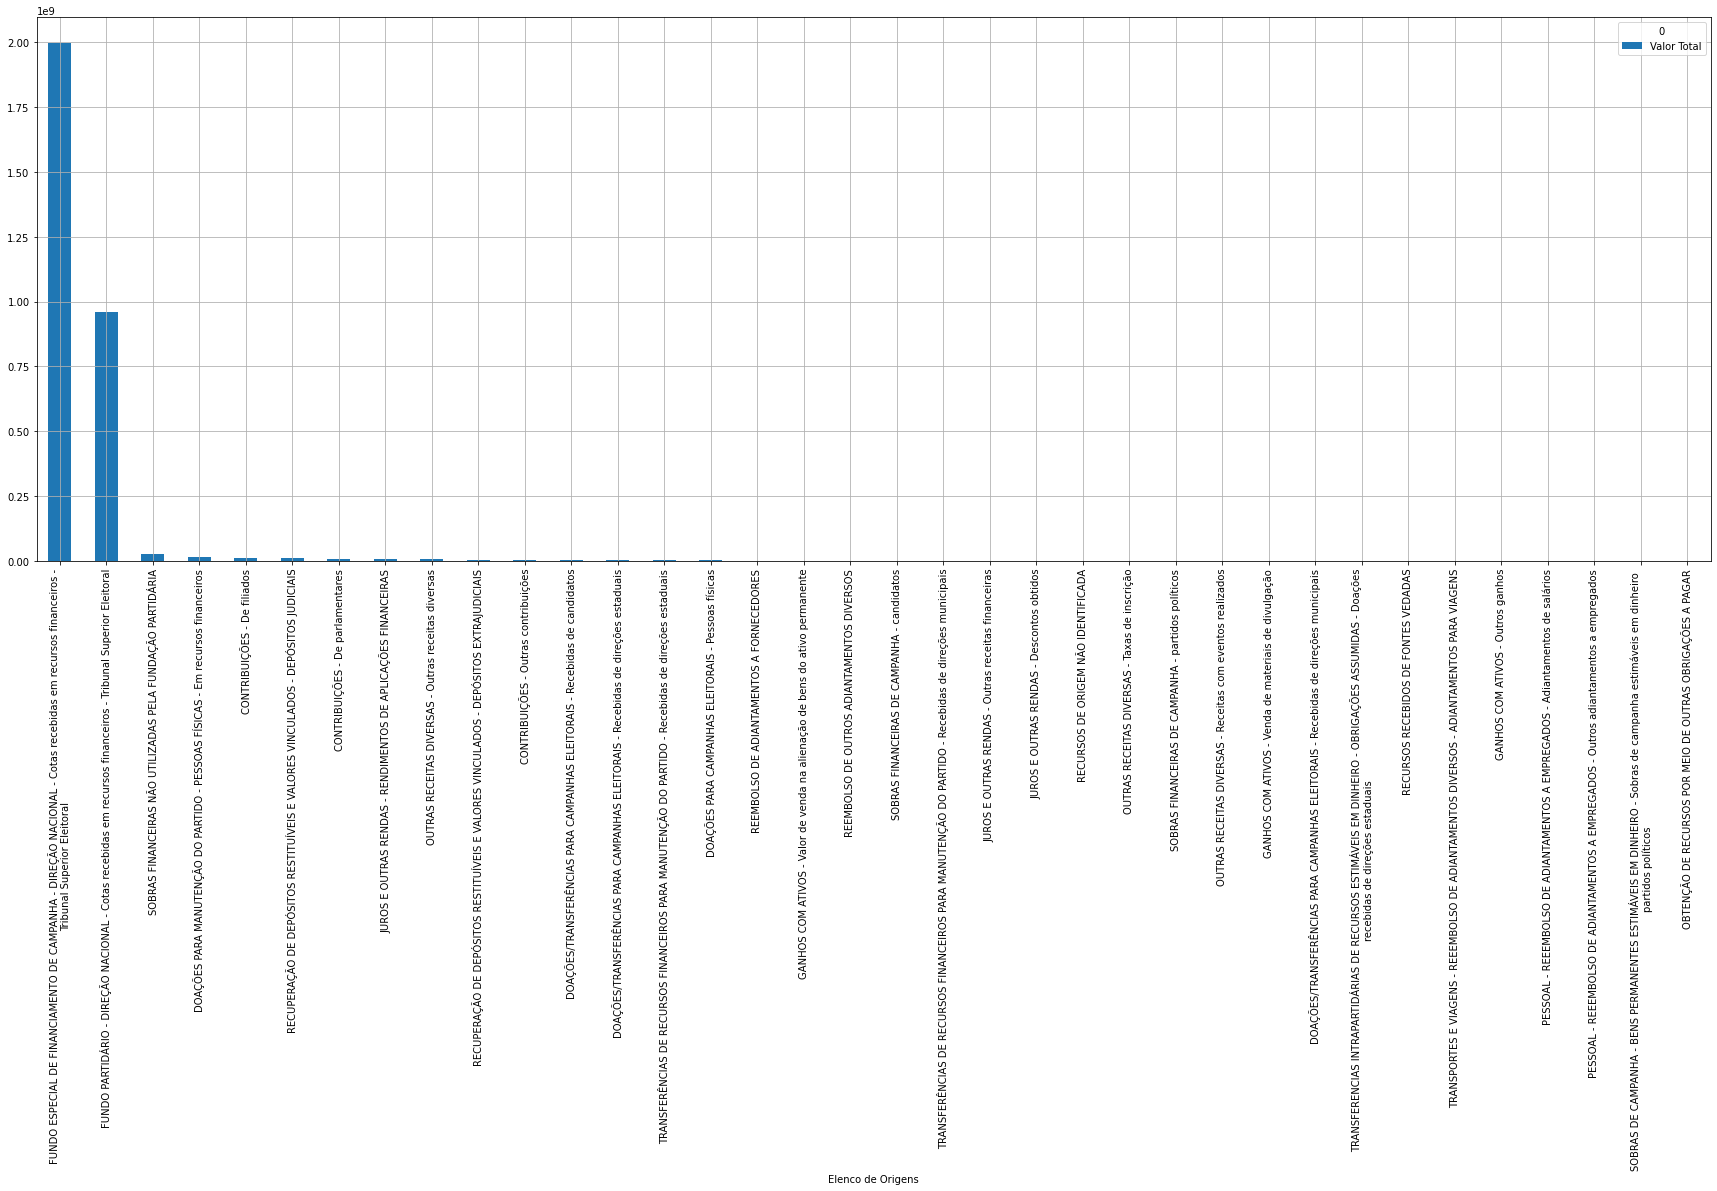

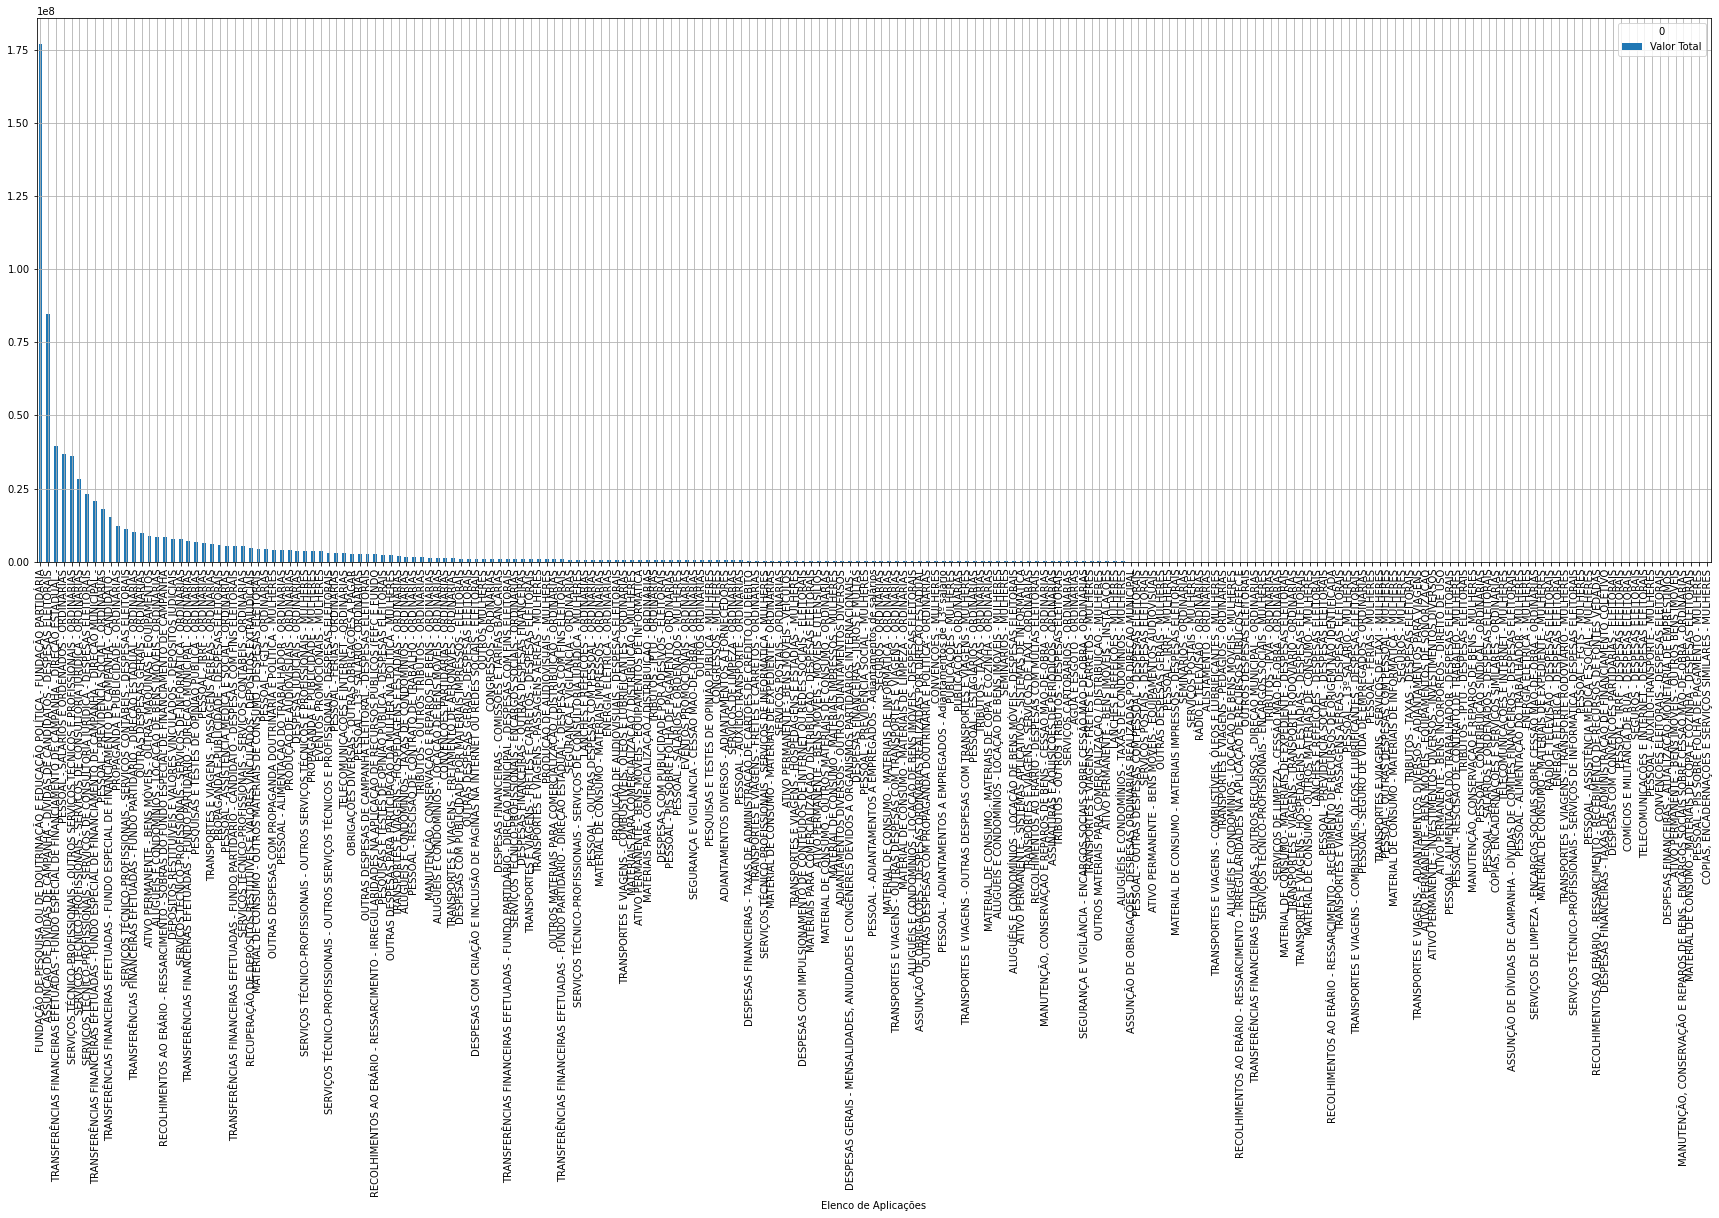

In [154]:
# Plot dos gráficos
df_grouped_origin.plot(kind='bar', figsize=(30, 10))
# plt.yscale('log')
plt.grid(True)
plt.show()

df_grouped_aplic.plot(kind='bar', figsize=(30, 10))
# plt.yscale('log')
plt.grid(True)
plt.show()

